### Libraries & Dependencies

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import string
import numpy as np
import os

### Data Preprocessing

In [ ]:
data = pd.read_csv("Processed_ECG.csv")
data.loc[data["Label"] == 0.5, "Label"] = 1
data = data.iloc[-400:]
data['ECG_Simple'] = data['ECG'].str.strip('[]').str.split(',')
data = data[['ECG_Simple','Label']]
data = data.reset_index(drop=True)
print(data.shape)
data.head()

(400, 2)


,ECG_Simple,Label
0,"[0.66, 0.6399999999999999, 0.63, 0.65, 0.6...",1.0
1,"[0.47560975609756095, 0.6097560975609755, 0....",0.0
2,"[0.5303030303030303, 0.6212121212121212, 0.5...",1.0
3,"[0.48529411764705893, 0.5, 0.426470588235294...",0.0
4,"[0.620253164556962, 0.620253164556962, 0.632...",1.0


#### Select First 3 Elements from each ECG Row

In [ ]:
lst = data['ECG_Simple'].values.tolist()
lst2 = [item[:5] for item in lst]
lst3 = [item[0] for item in lst2]
lst4 = [item[1] for item in lst2]
lst5 = [item[2] for item in lst2]
lst6 = [item[3] for item in lst2]
lst7 = [item[4] for item in lst2]

#### Convert from String to Float

In [ ]:
featureDF = pd.DataFrame(
    {'f1': lst3,
     'f2': lst4,
     'f3': lst5,
     'f4': lst5,
     'f5': lst6,
     'f6': lst7
    })

featureDF = featureDF.astype(float)
featureDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      400 non-null    float64
 1   f2      400 non-null    float64
 2   f3      400 non-null    float64
 3   f4      400 non-null    float64
 4   f5      400 non-null    float64
 5   f6      400 non-null    float64
dtypes: float64(6)
memory usage: 18.9 KB


#### Join ECG Features with Label Column

In [ ]:
df =  pd.concat([data, featureDF], axis=1) 
df = df.drop(['ECG_Simple'], axis=1)
df = df[['f1','f2','f3','f4','f5','f6','Label']]
# df['Label'] =  df['Label'].astype(int)
df["Label"] = df["Label"].astype(int)
df.head()

,f1,f2,f3,f4,f5,f6,Label
0,0.660000,0.640000,0.630000,0.630000,0.650000,0.640000,1
1,0.475610,0.609756,0.634146,0.634146,0.634146,0.634146,0
2,0.530303,0.621212,0.530303,0.530303,0.712121,0.666667,1
3,0.485294,0.500000,0.426471,0.426471,0.588235,0.485294,0
4,0.620253,0.620253,0.632911,0.632911,0.620253,0.531646,1


#### Get Number of Samples for each Label

In [ ]:
df['Label'].value_counts()

1    200
0    200
Name: Label, dtype: int64

#### Seperate Train and Target Variables

In [ ]:
X_columns=[x for x in df.columns if x!='Label']
features=len(X_columns)

# split into input (X) and output (Y) variables
X = df[X_columns]
X = np.asarray(X).astype(np.float32)
X = np.resize(X,(X.shape[0],1,X.shape[1]))

y=df['Label']
# y = np.asarray(y).astype(np.float32)
# y = np.asarray(y).astype(np.int32)
y = np.asarray(y).astype(np.int64)

#### Split Dataset by 90:10 Ratio

In [ ]:
seed = 7
test_size = 0.90
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=False)

### LSTM Model Setup

In [ ]:
model = Sequential()
model.add(LSTM(20, activation='tanh', return_sequences=True, input_shape=(1, features)))
model.add(Dropout(0.2))
model.add(LSTM(10, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

### Train LSTM Model

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history=model.fit(X_train, y_train, epochs=10,batch_size=50,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 3.4906 - accuracy: 0.5000 - val_loss: 2.2195 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 28ms/step - loss: 2.5451 - accuracy: 0.5000 - val_loss: 2.0658 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 27ms/step - loss: 2.3666 - accuracy: 0.5000 - val_loss: 1.9686 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 25ms/step - loss: 2.0239 - accuracy: 0.5000 - val_loss: 1.8942 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 25ms/step - loss: 1.9301 - accuracy: 0.5000 - val_loss: 1.8334 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 27ms/step - loss: 2.3019 - accuracy: 0.5000 - val_loss: 1.7882 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 28ms/step - loss: 1.7724 - accuracy: 0.5000 - val_loss: 1.7497 - val_accuracy: 0.5000
Epoch 8/10
1/1 [=============

### Plot LSTM Model Results

12/12 [==============================] - 0s 1ms/step - loss: 1.6610 - accuracy: 0.5000
[1.6610397100448608, 0.5]


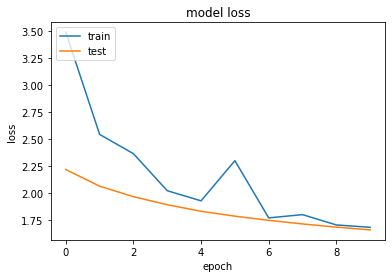

In [ ]:
print(model.evaluate(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# y_hat = model.predict(X_test)
# y_hat